In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from utils_db import load_table
from preprocess import drop_nan_df, analyze_df, clean_numstr

pd.set_option("display.max_columns", None)

In [2]:
# load table
df_raw = load_table("cars")
df_raw.head()

,car_id,url,brand,model,price,post_code,prod_year,mileage,gearbox,energy,attrs,crawled_at
0,701,https://www.lacentrale.fr/auto-occasion-annonc...,FERRARI,FERRARI 348,85 900 €,75016,1991,21 600 km,Manuelle,Essence,"{'Couleur': 'ROUGE FONCE', 'Sellerie': 'Noir',...",2025-05-22 17:59:50.761955
1,745,https://www.lacentrale.fr/auto-occasion-annonc...,CITROEN,CITROEN C3 III phase 2,12 990 €,33700,None,None,None,None,{'': ''},2025-05-22 18:27:18.279740
2,746,https://www.lacentrale.fr/auto-occasion-annonc...,AUDI,AUDI A3 II phase 3,9 990 €,95200,None,None,None,None,{'': ''},2025-05-22 18:28:45.179853
3,877,https://www.lacentrale.fr/auto-occasion-annonc...,FORD,FORD TOURNEO CUSTOM II FOURGON II phase 2,45 064 €,,2025,10 km,Manuelle,Diesel,"{'Couleur': 'blanc', 'Crit'Air': '', 'Norme eu...",2025-05-23 17:39:06.591229
4,1048,https://www.lacentrale.fr/auto-occasion-annonc...,MERCEDES,MERCEDES CLA phase 2,24 488 €,,2018,92 150 km,Automatique,Diesel,"{'Couleur': 'blanc', 'Crit'Air': '', 'Norme eu...",2025-05-23 19:47:47.443493


In [3]:
def expand_df(df_raw: pd.DataFrame)-> pd.DataFrame:
    # Expand attrs
    df_attrs = pd.json_normalize(df_raw["attrs"])
    df = pd.concat([df_raw.drop(columns=["attrs"]), df_attrs], axis=1)

    # Drop unwanted columns
    df.drop(columns=["car_id", "url", "crawled_at", "Crit'Air"], inplace=True)

    return df


def format_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    numstr_cols = [
        "price", "mileage", "Puissance DIN", "Puissance fiscale", "Longueur",
        "Emission de CO2",
    ]
    for col in numstr_cols:
        df[col] = df[col].apply(clean_numstr)

    int_cols = [
        "price", "prod_year", "mileage", "Nombre de places", "Puissance DIN", 
        "Nombre de portes", "Puissance fiscale", "Emission de CO2"
    ]
    for col in int_cols:
        df[col] = df[col].astype(int)

    df["Longueur"] = df["Longueur"].astype(float)

    df["post_code"] = np.where(
        df["post_code"] == "",
        "unknown",
        df["post_code"].str[:2]
    )

    df["Mise en circulation"] = pd.to_datetime(df["Mise en circulation"], format="%d/%m/%Y")
    df["circulation_year"] = df["Mise en circulation"].dt.year
    df.drop(columns=["Mise en circulation"], inplace=True)

    return df


df = expand_df(df_raw)
df = drop_nan_df(df)
df = format_df(df)
df.head()

,brand,model,price,post_code,prod_year,mileage,gearbox,energy,Couleur,Provenance,Première main,Nombre de places,Contrôle technique,Norme euro,Puissance DIN,Nombre de portes,Puissance fiscale,Longueur,Emission de CO2,circulation_year
8,FORD,FORD TRANSIT IV phase 2,19780,54,2020,87308,Manuelle,Diesel,Blanc,Non renseignée,Oui,3,Requis,EURO6,170,2,7,5.84,284,2020
9,SEAT,SEAT IBIZA IV,4980,72,2011,195000,Manuelle,Diesel,blanc,Non renseignée,Non,5,Requis,EURO5,75,5,4,4.03,99,2011
10,BMW,BMW SERIE 5 G60,87900,77,2025,7000,Automatique,Diesel,gris,Non renseignée,Oui,5,Non requis,EURO6,197,4,11,5.06,144,2025
11,ASTON MARTIN,ASTON MARTIN DB9 VOLANTE,114990,75,2016,37995,Automatique,Essence,gris,Non renseignée,Non,4,Requis,EURO6,548,2,48,4.69,325,2016
12,OPEL,OPEL MOKKA II,23900,10,2024,13912,Manuelle,Essence,blanc,Non renseignée,Non,5,Non requis,EURO6,136,5,7,4.15,127,2024


In [4]:
analyze_df(df)


-- shape --

(1091, 20)

-- data type --

brand                  object
model                  object
price                   int64
post_code              object
prod_year               int64
mileage                 int64
gearbox                object
energy                 object
Couleur                object
Provenance             object
Première main          object
Nombre de places        int64
Contrôle technique     object
Norme euro             object
Puissance DIN           int64
Nombre de portes        int64
Puissance fiscale       int64
Longueur              float64
Emission de CO2         int64
circulation_year        int32
dtype: object

-- unique values count --

brand                   40
model                  494
price                  518
post_code               81
prod_year               26
mileage               1010
gearbox                  2
energy                   8
Couleur                318
Provenance               3
Première main            2
Nombre de places  

# Distribution

1. Extreme values in price. -> log transform.
2. Too many categories in model, post_code. -> TargetEncoder
3. Too many categories in energy, Couleur. -> Rare Encoding

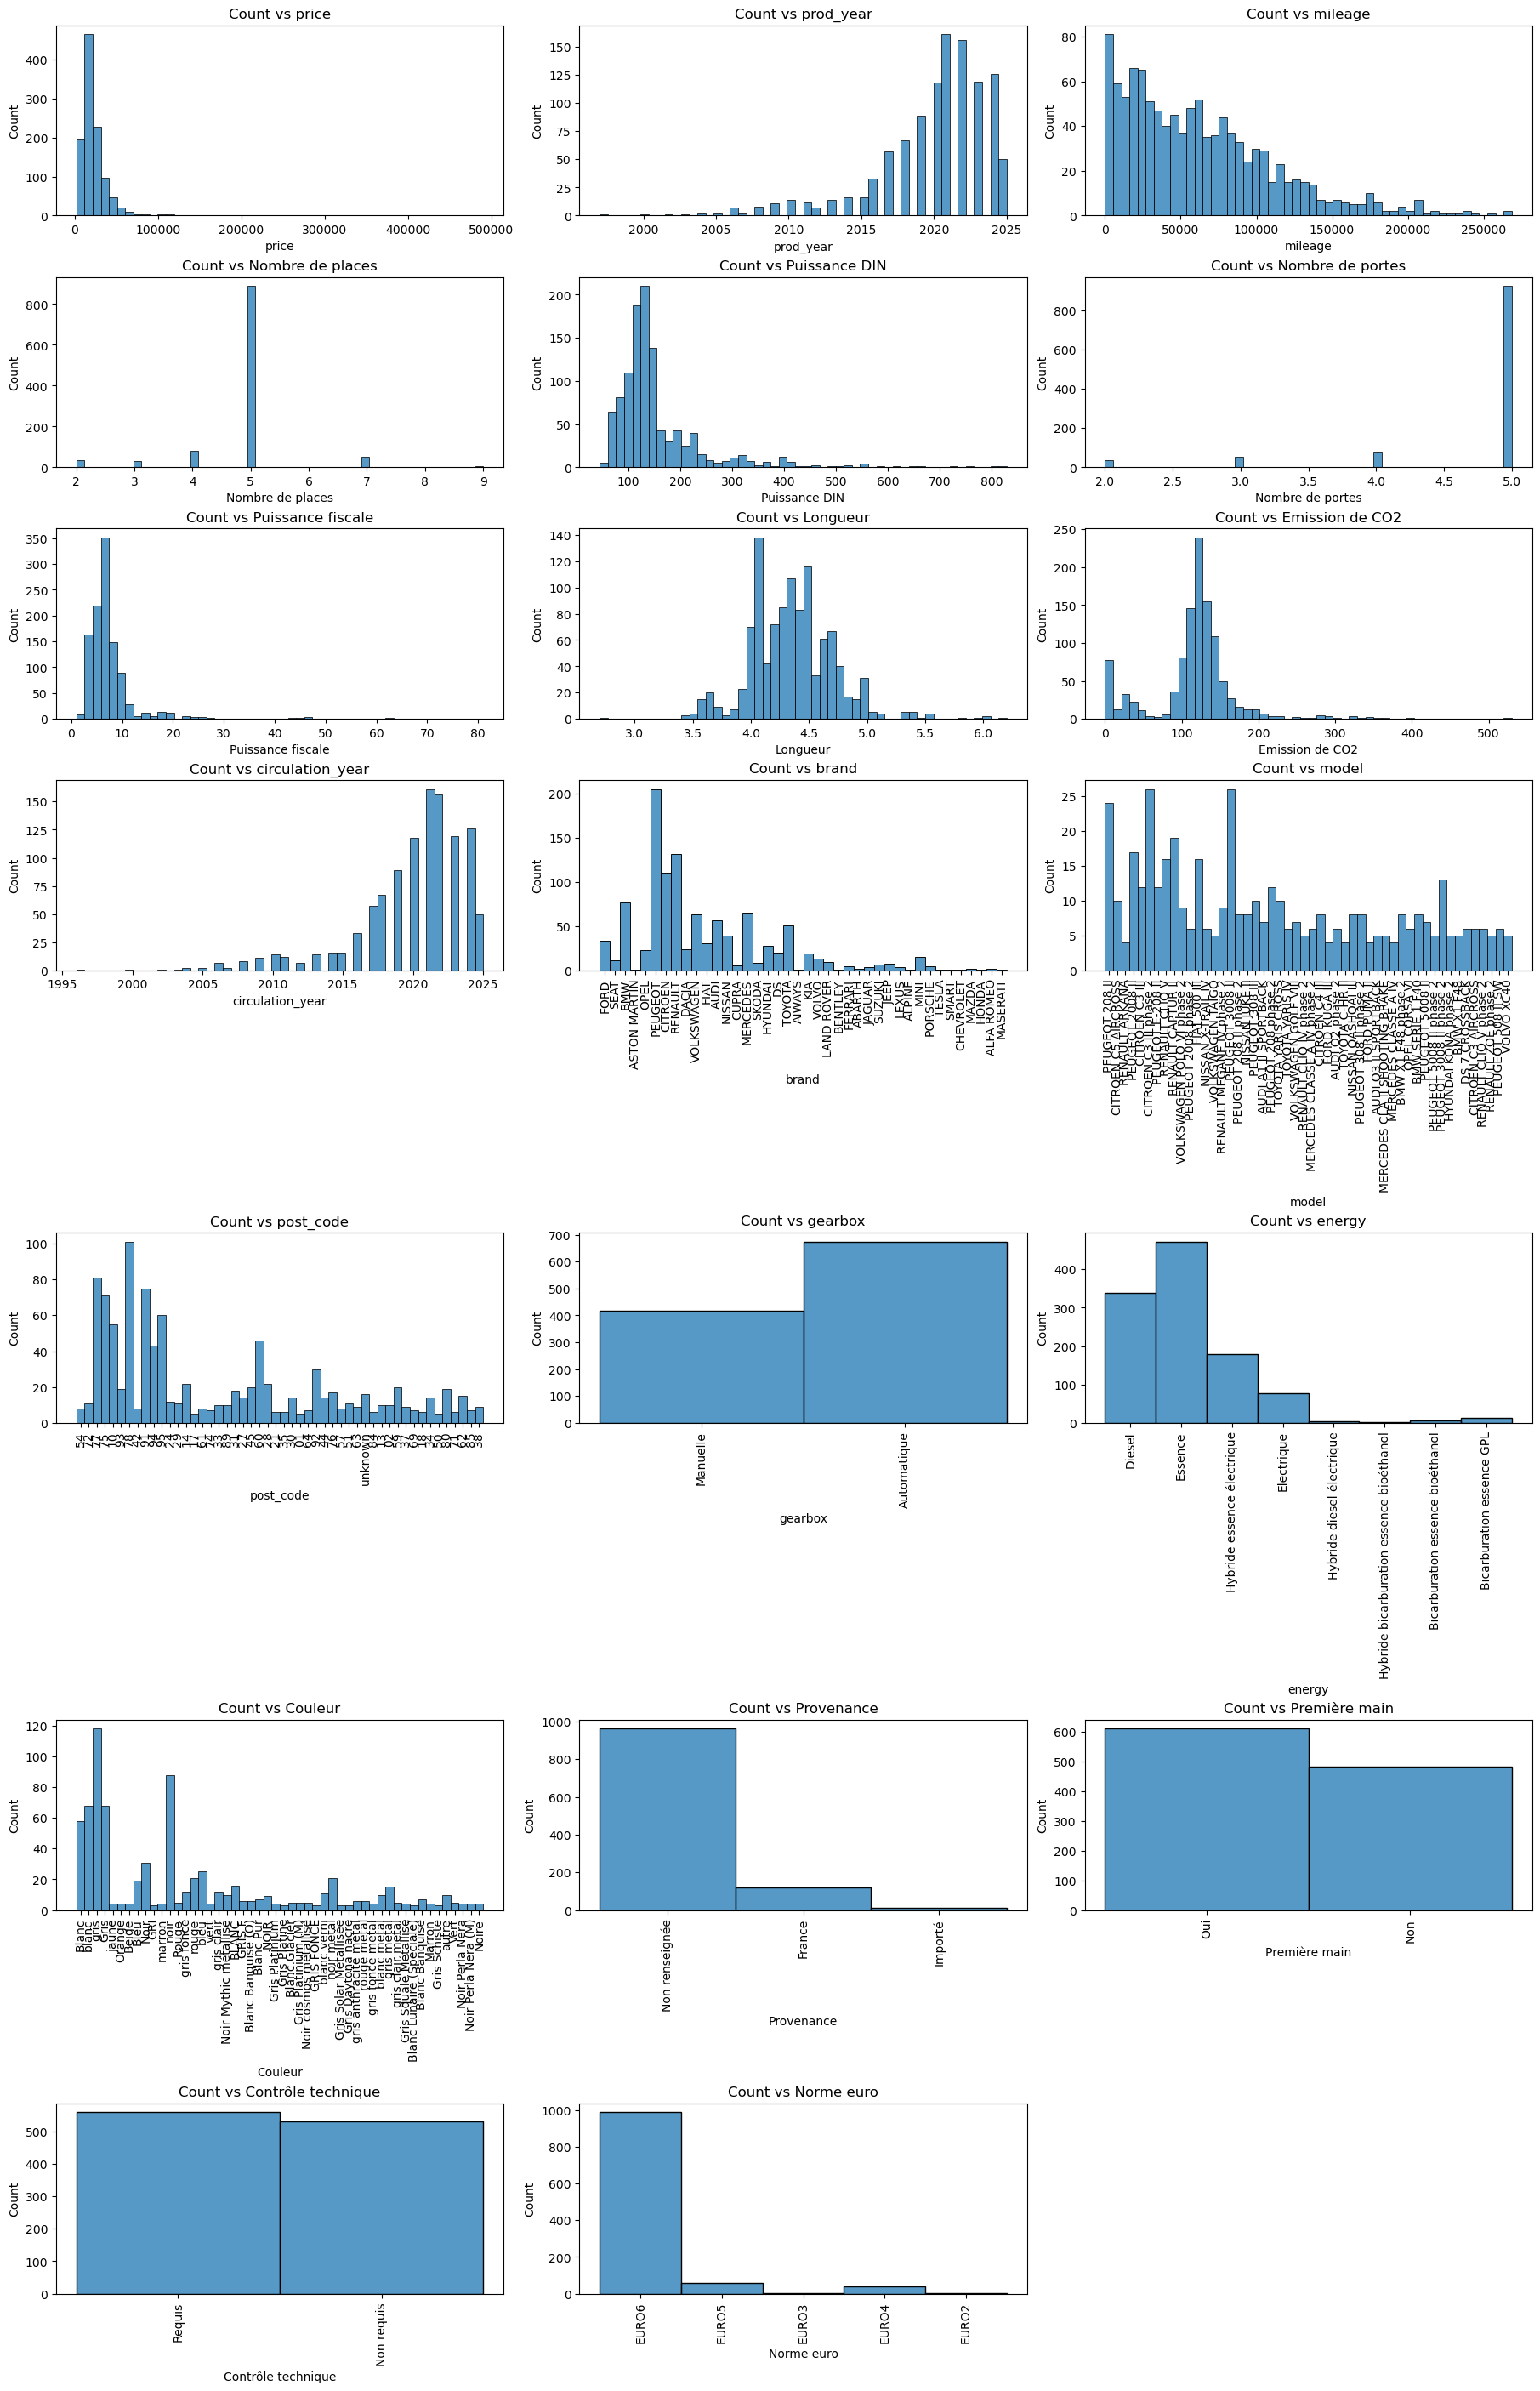

In [5]:
def plot_count_vs_features(df: pd.DataFrame):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 50
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        
        if col in numerical_cols:
            sns.histplot(data=df, x=col, bins=50, ax=ax, kde=False)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            sns.histplot(data=df_filtered, x=col, bins=50, ax=ax, kde=False)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"Count vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/count_vs_features.png")
    plt.show()


plot_count_vs_features(df)

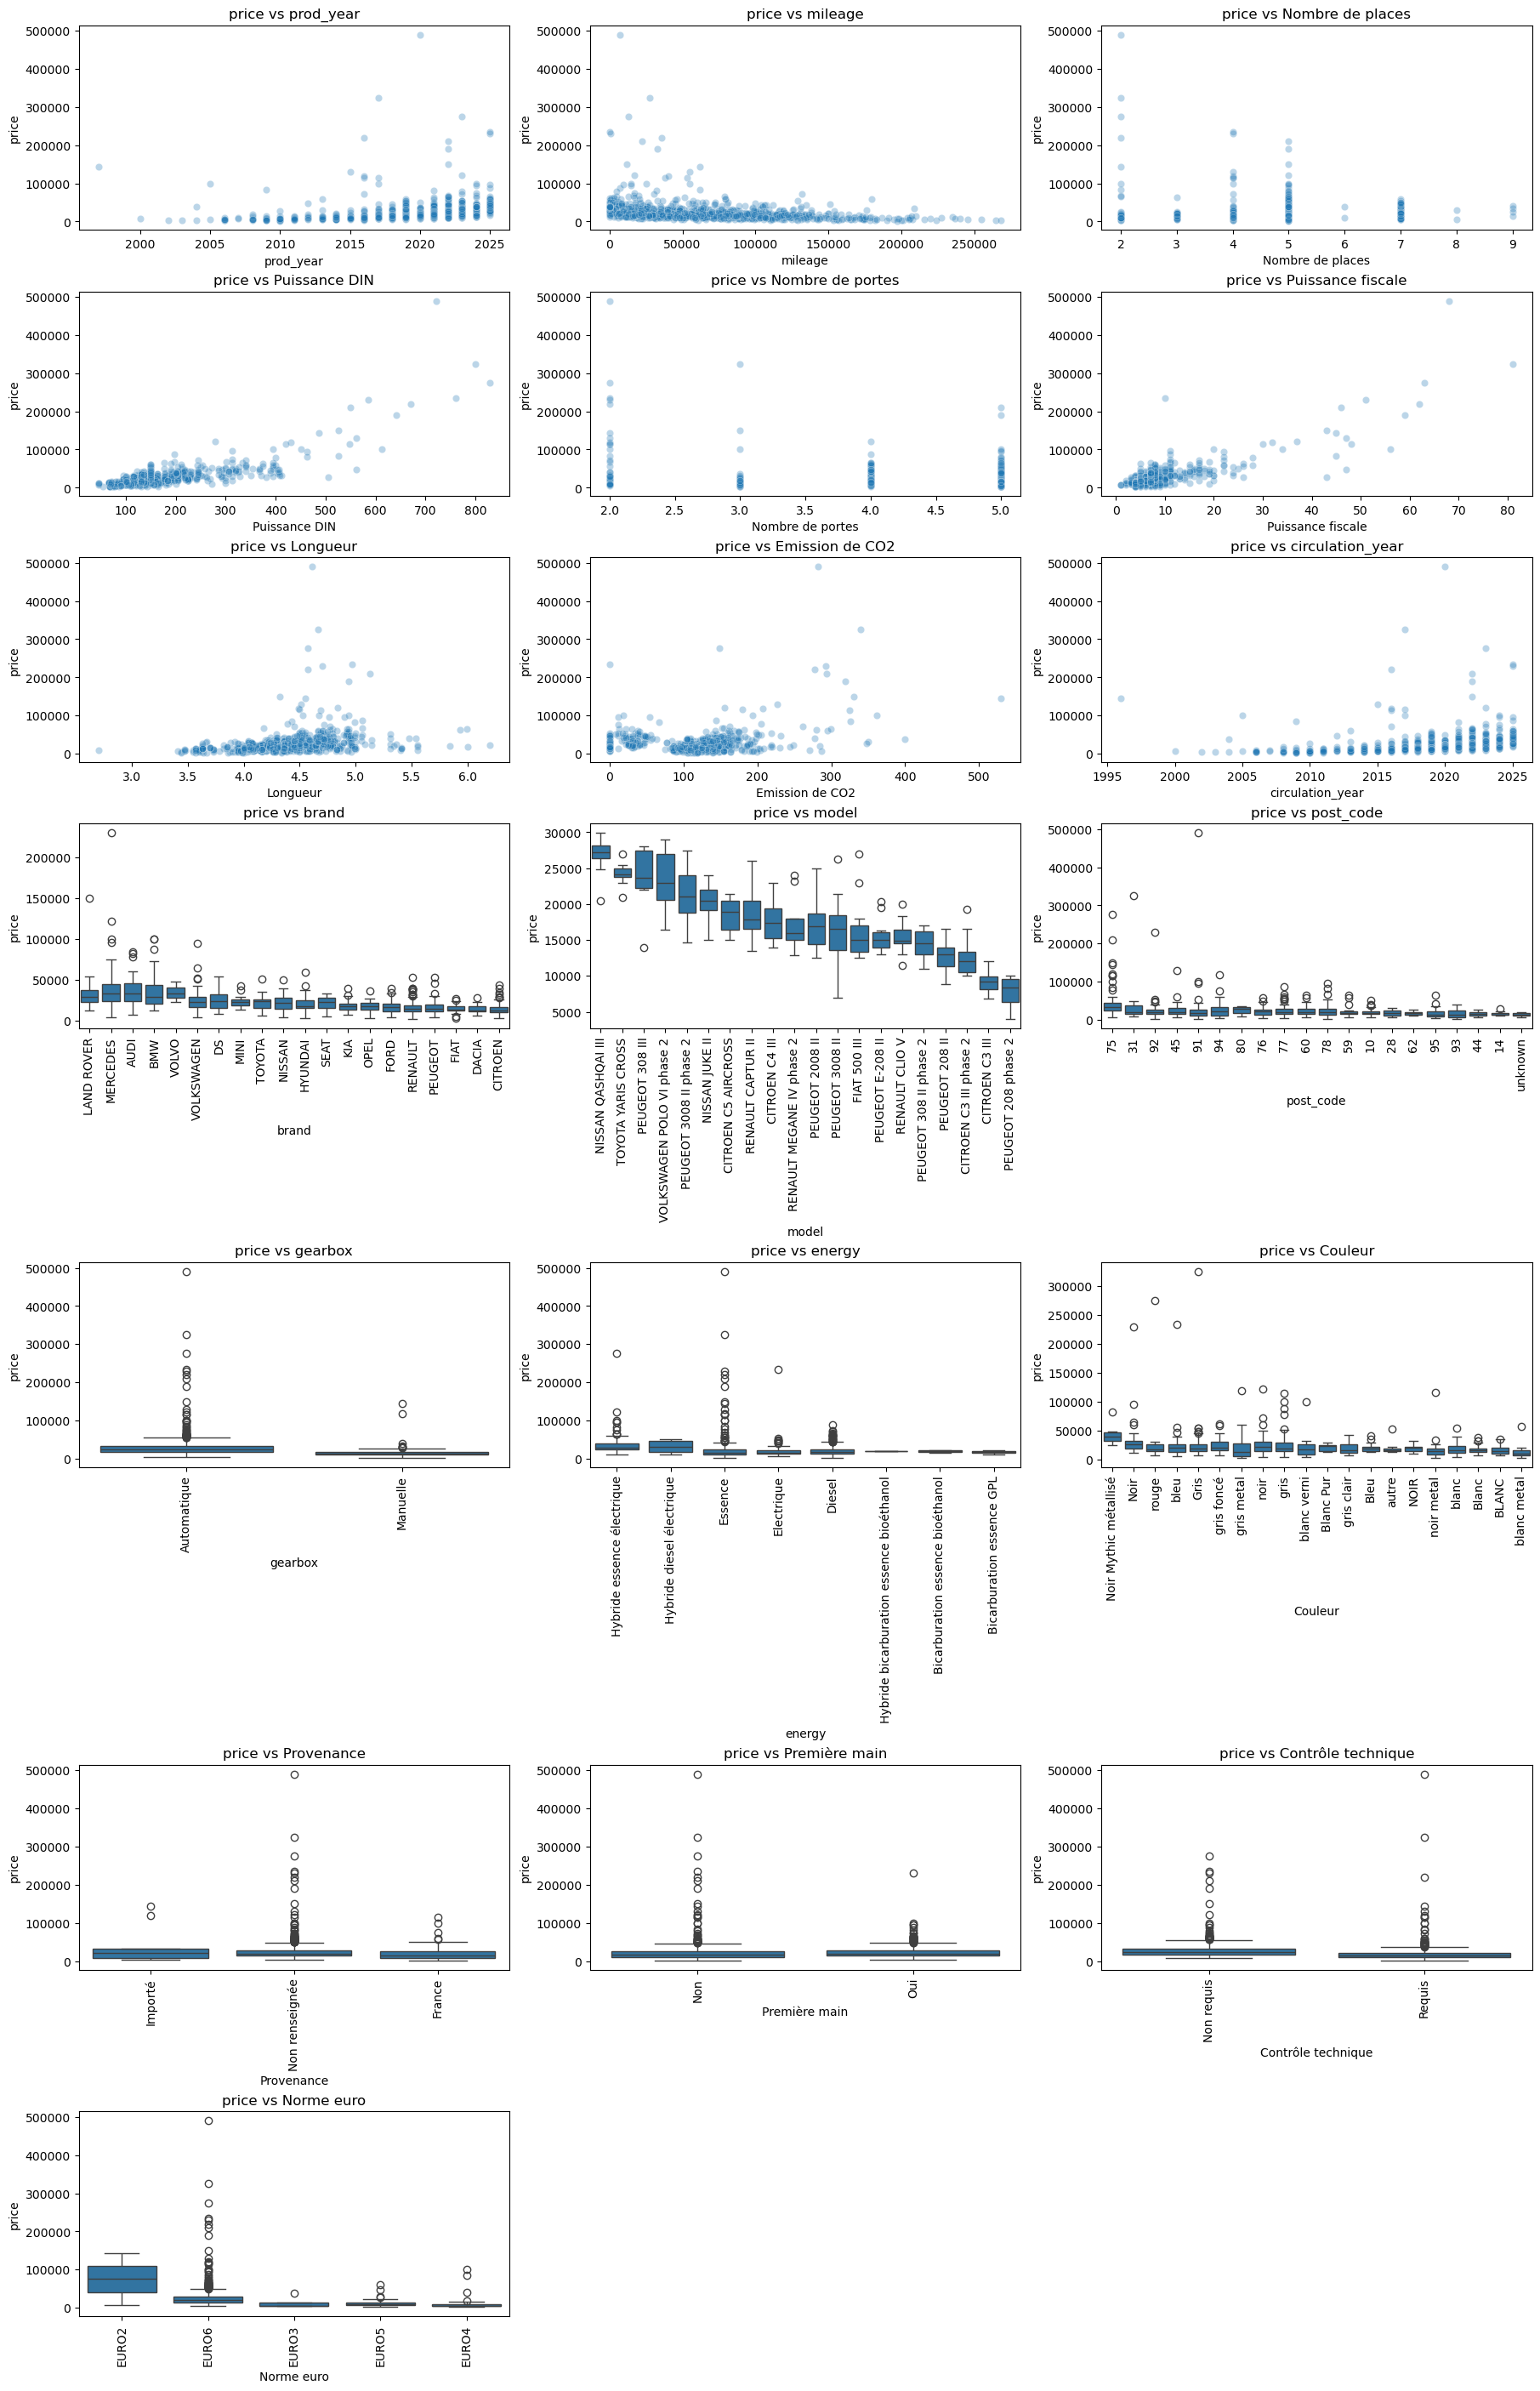

In [6]:
def plot_target_vs_features(df: pd.DataFrame, target: str):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove(target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 6, r * 4), constrained_layout=True)
    axes = axes.flatten()
    topk = 20
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in numerical_cols:
            sns.scatterplot(data=df, x=col, y=target, ax=ax, alpha=0.3)
        else:
            # Keep top frequent categories
            top_categories = df[col].value_counts().nlargest(topk).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            categories = (
                df_filtered.groupby(col)[target]
                .mean()
                .sort_values(ascending=False)
                .index
                .tolist()
            )
            sns.boxplot(data=df_filtered, x=col, y=target, ax=ax, order=categories)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"{target} vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig("results/target_vs_features.png")
    plt.show()


plot_target_vs_features(df, target="price")

# Correlation

1. High correlated features with price.  
Puissance fiscale, Puissance DIN

3. Multicollinearity.  
('prod_year', 'circulation_year'), ('Puissance DIN', 'Puissance fiscale')


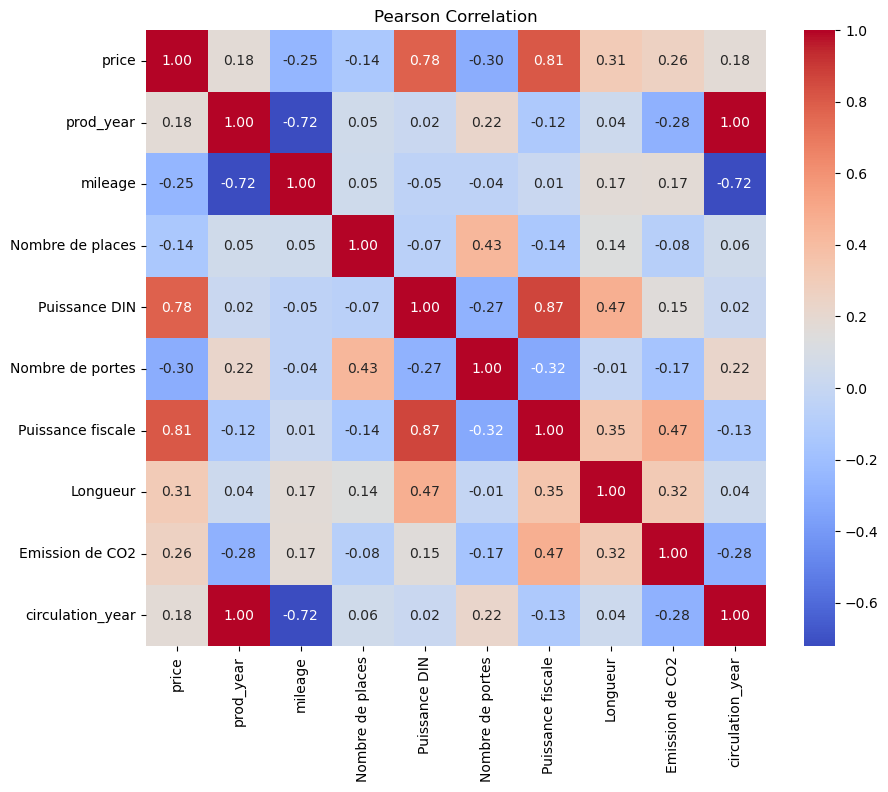

price                1.000000
Puissance fiscale    0.809156
Puissance DIN        0.782170
Longueur             0.312882
Nombre de portes     0.300667
Emission de CO2      0.262518
mileage              0.254725
prod_year            0.177634
circulation_year     0.176418
Nombre de places     0.141283
Name: price, dtype: float64


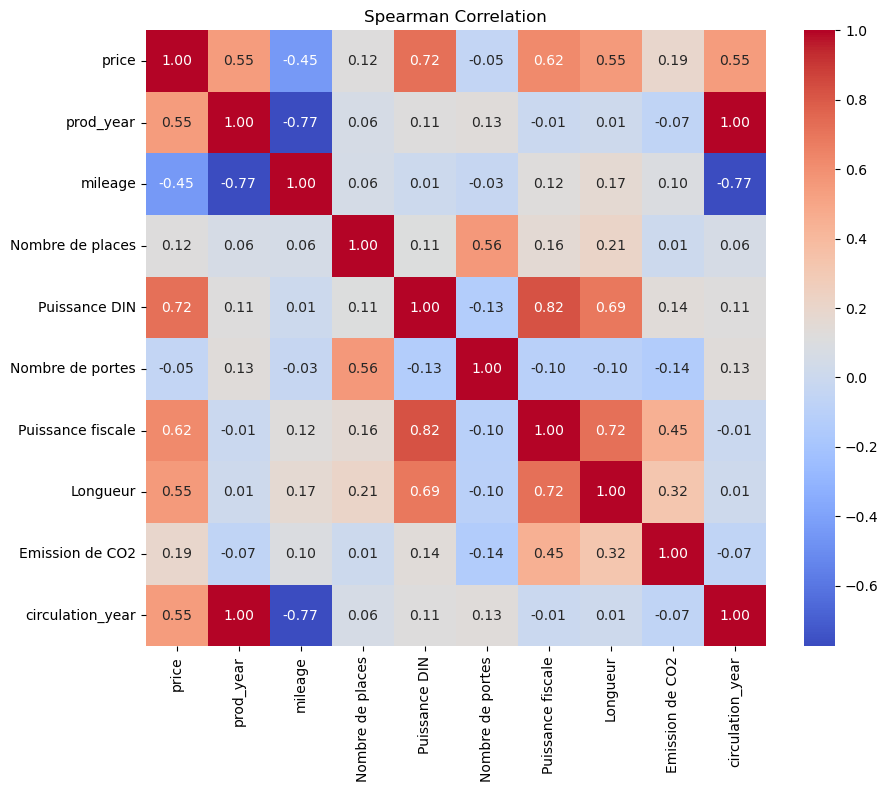

price                1.000000
Puissance DIN        0.717705
Puissance fiscale    0.618911
Longueur             0.552244
prod_year            0.547998
circulation_year     0.547998
mileage              0.446996
Emission de CO2      0.193162
Nombre de places     0.117468
Nombre de portes     0.048452
Name: price, dtype: float64


In [7]:
def plot_corr(df: pd.DataFrame, target: str | None = None, method: str = "pearson"):
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr(method=method)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{method} Correlation".title())
    plt.show()

    if target:
        target_corr = corr_matrix["price"].abs().sort_values(ascending=False)
        
        print(target_corr)


plot_corr(df, target="price", method="pearson")
plot_corr(df, target="price", method="spearman")

In [8]:
def compute_corr_pairs(df: pd.DataFrame, threshold=0.8):
    """
    Compute correlation pairs to address multicollinearity
    """
    df_numerical = df.select_dtypes(include=['number'])
    corr_matrix = df_numerical.corr()
    
    pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col1, col2 = cols[i], cols[j]
            corr = corr_matrix.loc[col1, col2]
            if abs(corr) > threshold:
                pairs.append((col1, col2, float(corr)))
    pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
    print("\n-- Correlation Pairs --\n")
    print(pairs)


compute_corr_pairs(df)


-- Correlation Pairs --

[('prod_year', 'circulation_year', 0.9999726921410493), ('Puissance DIN', 'Puissance fiscale', 0.8662820832254352), ('price', 'Puissance fiscale', 0.8091561894256003)]
